# Assignment 1 - Algorithms and Data Structures Analysis

## What This Notebook Does

This notebook tests and compares different algorithms:
1. **UnionFind** - 4 different ways to solve the "connected components" problem
2. **3Sum** - 3 different ways to find triplets that sum to zero

## How to Use

1. **Run all cells** to see the performance analysis
2. **Check the plots** to see which algorithms are faster
3. **Look at the timing results** to understand Big O complexity

## What You'll See

- **Timing measurements** for different input sizes
- **Performance plots** showing which algorithms scale better
- **Real examples** of how the algorithms work


In [ ]:
import sys

sys.path.append("../src")

import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from threesum import (
    generate_test_data,
    three_sum_brute_force,
    three_sum_optimized,
    three_sum_optimized_with_hash,
)
from unionfind import (
    QuickFind,
    QuickUnion,
    WeightedQuickUnion,
    WeightedQuickUnionPathCompression,
)

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

random.seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

Libraries imported successfully!
Python version: 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:09:17) [GCC 11.2.0]
NumPy version: 2.0.1
Pandas version: 2.3.2
Matplotlib version: 3.10.5


In [2]:
def setup_unionfind_test(uf_class, n: int, operations: list[tuple[int, int]]):
    """Setup UnionFind instance and operations for %timeit testing."""
    uf = uf_class(n)

    def run_operations():
        for p, q in operations:
            uf.union(p, q)

    return run_operations


def generate_unionfind_operations(n: int, num_operations: int) -> list[tuple[int, int]]:
    """Generate random union operations for testing."""
    operations = []
    for _ in range(num_operations):
        p = random.randint(0, n - 1)
        q = random.randint(0, n - 1)
        operations.append((p, q))
    return operations


def setup_threesum_test(func, nums: list[int]):
    """Setup 3Sum function for %timeit testing."""

    def run_threesum():
        return func(nums)

    return run_threesum


print("Performance measurement functions defined!")

Performance measurement functions defined!


In [ ]:
print("=== UnionFind Performance Analysis with %timeit ===")

n_values = [100, 500, 1000, 2000, 5000]
num_operations = 1000

uf_algorithms = [
    ("Quick Find", QuickFind),
    ("Quick Union", QuickUnion),
    ("Weighted Quick Union", WeightedQuickUnion),
    ("Weighted Quick Union + Path Compression", WeightedQuickUnionPathCompression),
]

uf_results = []

for n in n_values:
    print(f"\nTesting with N = {n}")
    operations = generate_unionfind_operations(n, num_operations)

    for name, uf_class in uf_algorithms:
        test_func = setup_unionfind_test(uf_class, n, operations)

        result = %timeit -q -o test_func()  # pyright: ignore

        uf_results.append(
            {
                "Algorithm": name,
                "N": n,
                "Operations": num_operations,
                "Time (s)": result.best,
                "Average (s)": result.average,
            }
        )
        print(f"  {name}: {result.best:.6f}s (best), {result.average:.6f}s (avg)")

print(f"\nUnionFind analysis completed! {len(uf_results)} measurements taken.")

=== UnionFind Performance Analysis with %timeit ===

Testing with N = 100
  Quick Find: 0.000061s (best), 0.000061s (avg)
  Quick Union: 0.000514s (best), 0.000541s (avg)
  Weighted Quick Union: 0.000138s (best), 0.000140s (avg)
  Weighted Quick Union + Path Compression: 0.000155s (best), 0.000158s (avg)

Testing with N = 500
  Quick Find: 0.000077s (best), 0.000079s (avg)
  Quick Union: 0.002201s (best), 0.002285s (avg)
  Weighted Quick Union: 0.000175s (best), 0.000176s (avg)
  Weighted Quick Union + Path Compression: 0.000179s (best), 0.000180s (avg)

Testing with N = 1000
  Quick Find: 0.000071s (best), 0.000073s (avg)
  Quick Union: 0.002675s (best), 0.002756s (avg)
  Weighted Quick Union: 0.000183s (best), 0.000185s (avg)
  Weighted Quick Union + Path Compression: 0.000170s (best), 0.000174s (avg)

Testing with N = 2000
  Quick Find: 0.000069s (best), 0.000071s (avg)
  Quick Union: 0.000318s (best), 0.000324s (avg)
  Weighted Quick Union: 0.000150s (best), 0.000151s (avg)
  Weigh

In [ ]:
print("=== 3Sum Performance Analysis with %timeit ===")

array_sizes = [50, 100, 200, 500, 1000]
threesum_algorithms = [
    ("Brute Force", three_sum_brute_force),
    ("Optimized Two Pointers", three_sum_optimized),
    ("Hash Set", three_sum_optimized_with_hash),
]

threesum_results = []

for size in array_sizes:
    print(f"\nTesting with array size = {size}")

    test_data = generate_test_data(size)

    for name, func in threesum_algorithms:
        test_func = setup_threesum_test(func, test_data)

        sample_result = func(test_data)
        result = %timeit -q -o test_func()  # pyright: ignore

        threesum_results.append(
            {
                "Algorithm": name,
                "Array Size": size,
                "Time (s)": result.best,
                "Average (s)": result.average,
                "Solutions Found": len(sample_result),
            }
        )
        print(
            f"  {name}: {result.best:.6f}s (best), "
            f"{result.average:.6f}s (avg), {len(sample_result)} solutions"
        )

print(f"\n3Sum analysis completed! {len(threesum_results)} measurements taken.")

=== 3Sum Performance Analysis with %timeit ===

Testing with array size = 50
  Brute Force: 0.000587s (best), 0.000588s (avg), 71 solutions
  Optimized Two Pointers: 0.000054s (best), 0.000055s (avg), 49 solutions
  Hash Set: 0.000169s (best), 0.000171s (avg), 64 solutions

Testing with array size = 100
  Brute Force: 0.004564s (best), 0.004573s (avg), 612 solutions
  Optimized Two Pointers: 0.000192s (best), 0.000195s (avg), 295 solutions
  Hash Set: 0.000703s (best), 0.000722s (avg), 501 solutions

Testing with array size = 200
  Brute Force: 0.034761s (best), 0.036162s (avg), 4734 solutions
  Optimized Two Pointers: 0.000625s (best), 0.000625s (avg), 1132 solutions
  Hash Set: 0.002920s (best), 0.002996s (avg), 3765 solutions

Testing with array size = 500
  Brute Force: 0.693143s (best), 0.707009s (avg), 79605 solutions
  Optimized Two Pointers: 0.002506s (best), 0.002558s (avg), 4149 solutions
  Hash Set: 0.021083s (best), 0.022121s (avg), 55745 solutions

Testing with array size 

=== Creating Performance Visualizations ===


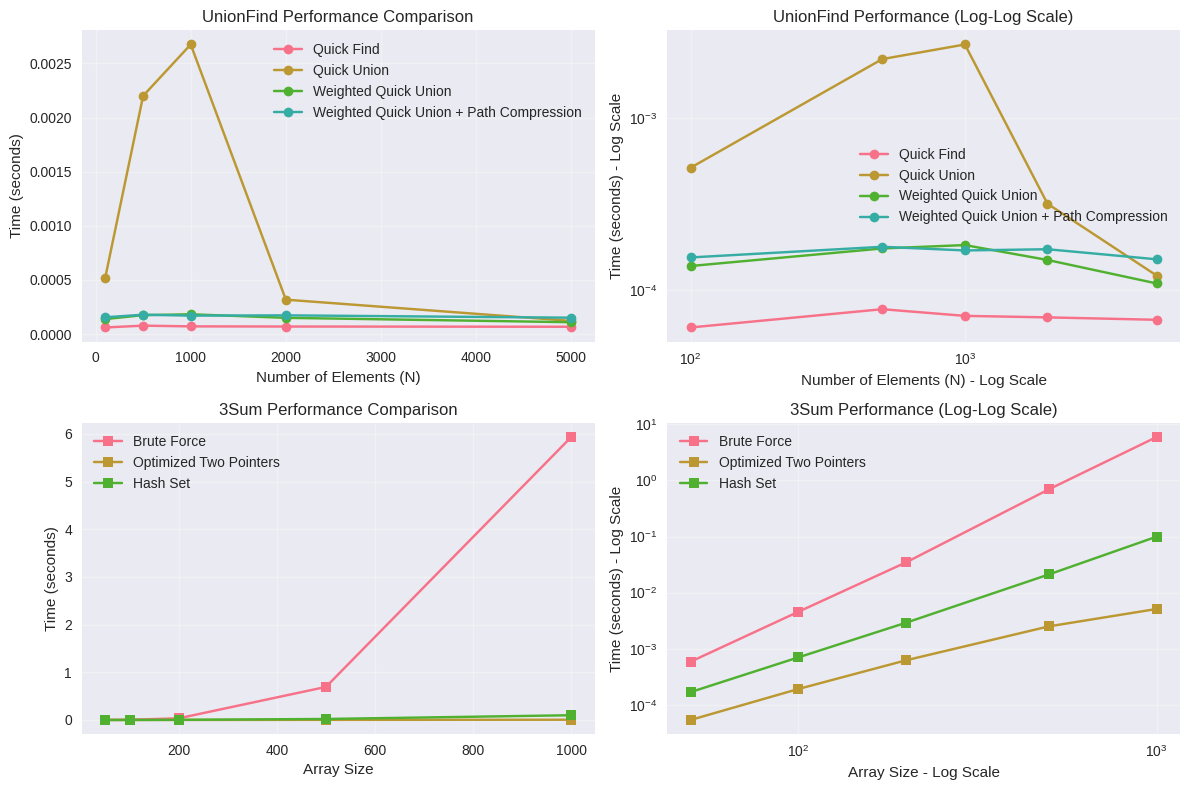

Visualizations created successfully!


In [5]:
print("=== Creating Performance Visualizations ===")

uf_df = pd.DataFrame(uf_results)
threesum_df = pd.DataFrame(threesum_results)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
for algorithm in uf_df["Algorithm"].unique():
    data = uf_df[uf_df["Algorithm"] == algorithm]
    plt.plot(data["N"], data["Time (s)"], marker="o", label=algorithm)
plt.xlabel("Number of Elements (N)")
plt.ylabel("Time (seconds)")
plt.title("UnionFind Performance Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
for algorithm in uf_df["Algorithm"].unique():
    data = uf_df[uf_df["Algorithm"] == algorithm]
    plt.loglog(data["N"], data["Time (s)"], marker="o", label=algorithm)
plt.xlabel("Number of Elements (N) - Log Scale")
plt.ylabel("Time (seconds) - Log Scale")
plt.title("UnionFind Performance (Log-Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
for algorithm in threesum_df["Algorithm"].unique():
    data = threesum_df[threesum_df["Algorithm"] == algorithm]
    plt.plot(data["Array Size"], data["Time (s)"], marker="s", label=algorithm)
plt.xlabel("Array Size")
plt.ylabel("Time (seconds)")
plt.title("3Sum Performance Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
for algorithm in threesum_df["Algorithm"].unique():
    data = threesum_df[threesum_df["Algorithm"] == algorithm]
    plt.loglog(data["Array Size"], data["Time (s)"], marker="s", label=algorithm)
plt.xlabel("Array Size - Log Scale")
plt.ylabel("Time (seconds) - Log Scale")
plt.title("3Sum Performance (Log-Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations created successfully!")